# Stonks 

Use tensorflow to build deep learning based time series forcasting models based on financial data.

Try out different neural network architectures, see which one works best for this task.

Keep track of the performance of all of the models.

Read the official Tensorflow time series forecasting [guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

mpl.rcParams['figure.figsize'] = (16, 9)

### Dataset

Currently using `yfinance` to access yahoo finance historical data since it is free.

In [118]:
tickers = ['SPY', 'AAPL', 'MSFT', 'TSLA', 'TQQQ', 'MS', 'GS', 'AMZN', 'NFLX', 'GOOG', 'XLF', 'WMT', 'GE', 'VZ', 'BAC', 'GLD', 'SLV']

In [119]:
def create_yfinance_df(tickers):
    return yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = 'max',

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )


In [120]:
multi_index_column_ticker_df = create_yfinance_df(tickers)

[*********************100%***********************]  17 of 17 completed


What do the first few entries look like? These should be the oldest.

In [121]:
multi_index_column_ticker_df.head()

GLD                       TSLA                        ...  \
           Open High Low Close Volume Open High Low Close Volume  ...   
Date                                                              ...   
1962-01-02  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1962-01-03  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1962-01-04  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1962-01-05  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1962-01-08  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   

                  GE                                          MSFT           \
                Open      High       Low     Close     Volume Open High Low   
Date                                                                          
1962-01-02  0.001785  0.001815  0.001767  0.001779  2156500.0  NaN  NaN NaN   
1962-01-03  0.001770  0.001770  0.001755  0.001761  1477600.0  NaN  NaN NaN   
1962-01-04  0.001761  0.001776  0.001725  0.001740  1837000.0  NaN  NaN NaN   
1962-01-05  0.001740  0.001743  0.001666  0.001696  2725600.0  NaN  NaN NaN   
1962-01-08  0.001696  0.001696  0.001642  0.001693  3095000.0  NaN  NaN NaN   

                         
           Close Volume  
Date                     
1962-01-02   NaN    NaN  
1962-01-03   NaN    NaN  
1962-01-04   NaN    NaN  
1962-01-05   NaN    NaN  
1962-01-08   NaN    NaN  

[5 rows x 85 columns]

What do the last few entries look like? These should be the newest.

In [122]:
multi_index_column_ticker_df.tail()

GLD                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-09-03  182.300003  182.820007  180.490005  181.139999  12148100.0   
2020-09-04  180.949997  182.100006  180.050003  181.639999  11567900.0   
2020-09-08  179.500000  182.270004  179.020004  181.289993  13229200.0   
2020-09-09  182.500000  183.220001  182.190002  183.050003   8410500.0   
2020-09-10  184.229996  184.679993  182.279999  182.460007   8990244.0   

                  TSLA                                                   ...  \
                  Open        High         Low       Close       Volume  ...   
Date                                                                     ...   
2020-09-03  407.230011  431.799988  402.000000  407.000000   87596100.0  ...   
2020-09-04  402.809998  428.000000  372.019989  418.320007  110321900.0  ...   
2020-09-08  356.000000  368.739990  329.880005  330.209991  115465700.0  ...   
2020-09-09  356.600006  369.000000  341.510010  366.279999   78582200.0  ...   
2020-09-10  386.209991  398.989990  360.559998  371.339996   83488861.0  ...   

              GE                                       MSFT              \
            Open  High   Low Close       Volume        Open        High   
Date                                                                      
2020-09-03  6.39  6.65  6.28  6.32   94124900.0  229.270004  229.309998   
2020-09-04  6.43  6.56  6.26  6.42   89675900.0  215.100006  218.360001   
2020-09-08  6.32  6.36  6.13  6.14  120646000.0  206.500000  210.029999   
2020-09-09  6.20  6.20  6.02  6.16  108940200.0  207.600006  214.839996   
2020-09-10  6.17  6.20  6.00  6.00   95780460.0  213.399994  214.729996   

                                                
                   Low       Close      Volume  
Date                                            
2020-09-03  214.960007  217.300003  58400300.0  
2020-09-04  205.190002  214.250000  59664100.0  
2020-09-08  202.199997  202.660004  52924300.0  
2020-09-09  206.699997  211.289993  45582200.0  
2020-09-10  204.110001  205.369995  33722693.0  

[5 rows x 85 columns]

In [123]:
multi_index_column_ticker_df.dtypes

GLD   Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume    float64
                 ...   
MSFT  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume    float64
Length: 85, dtype: object

Is the data properly indexed by date already for me?

In [124]:
multi_index_column_ticker_df.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '2020-08-27', '2020-08-28', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-08',
               '2020-09-09', '2020-09-10'],
              dtype='datetime64[ns]', name='Date', length=14778, freq=None)

Seems like it, I should be able to select date ranges

In [125]:
multi_index_column_ticker_df['2020-08-27':'2020-08-31']

GLD                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-08-27  185.000000  185.169998  179.369995  181.240005  16299200.0   
2020-08-28  183.979996  185.399994  183.399994  184.389999  13200800.0   
2020-08-31  184.789993  185.529999  184.279999  184.830002  10251200.0   

                  TSLA                                                   ...  \
                  Open        High         Low       Close       Volume  ...   
Date                                                                     ...   
2020-08-27  436.092010  459.119995  428.500000  447.750000  118465000.0  ...   
2020-08-28  459.023987  463.697998  437.303986  442.679993  100406000.0  ...   
2020-08-31  444.609985  500.140015  440.109985  498.320007  118374400.0  ...   

              GE                                       MSFT              \
            Open  High   Low Close       Volume        Open        High   
Date                                                                      
2020-08-27  6.52  6.63  6.45  6.48   73387900.0  222.889999  231.149994   
2020-08-28  6.51  6.62  6.47  6.61   59161700.0  228.179993  230.639999   
2020-08-31  6.51  6.69  6.26  6.34  141873000.0  227.000000  228.699997   

                                                
                   Low       Close      Volume  
Date                                            
2020-08-27  219.399994  226.580002  57602200.0  
2020-08-28  226.580002  228.910004  26292900.0  
2020-08-31  224.309998  225.529999  28774200.0  

[3 rows x 85 columns]

In [126]:
multi_index_column_ticker_df.columns

MultiIndex([( 'GLD',   'Open'),
            ( 'GLD',   'High'),
            ( 'GLD',    'Low'),
            ( 'GLD',  'Close'),
            ( 'GLD', 'Volume'),
            ('TSLA',   'Open'),
            ('TSLA',   'High'),
            ('TSLA',    'Low'),
            ('TSLA',  'Close'),
            ('TSLA', 'Volume'),
            ( 'SLV',   'Open'),
            ( 'SLV',   'High'),
            ( 'SLV',    'Low'),
            ( 'SLV',  'Close'),
            ( 'SLV', 'Volume'),
            ('GOOG',   'Open'),
            ('GOOG',   'High'),
            ('GOOG',    'Low'),
            ('GOOG',  'Close'),
            ('GOOG', 'Volume'),
            (  'GS',   'Open'),
            (  'GS',   'High'),
            (  'GS',    'Low'),
            (  'GS',  'Close'),
            (  'GS', 'Volume'),
            ('NFLX',   'Open'),
            ('NFLX',   'High'),
            ('NFLX',    'Low'),
            ('NFLX',  'Close'),
            ('NFLX', 'Volume'),
            (  'MS',   'Open'),
        

We see that this dataframe has multi index columns. Accessing an underlying symbol's data in a multi index can be done like this

In [127]:
multi_index_column_ticker_df['2020-08-27':'2020-08-31']['TSLA']

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-27,436.092010,459.119995,428.500000,447.750000,118465000.0
2020-08-28,459.023987,463.697998,437.303986,442.679993,100406000.0
2020-08-31,444.609985,500.140015,440.109985,498.320007,118374400.0


Lets describe some common stats for each feature

In [128]:
multi_index_column_ticker_df.describe().transpose()

count          mean           std           min           25%  \
GLD  Open    3980.0  1.118106e+02  3.454562e+01  4.103000e+01  8.936250e+01   
     High    3980.0  1.123820e+02  3.467483e+01  4.136000e+01  9.000500e+01   
     Low     3980.0  1.111928e+02  3.438904e+01  4.102000e+01  8.866000e+01   
     Close   3980.0  1.118099e+02  3.454258e+01  4.126000e+01  8.935750e+01   
     Volume  3980.0  9.828518e+06  7.217941e+06  3.193000e+05  5.207975e+06   
...             ...           ...           ...           ...           ...   
MSFT Open    8696.0  2.638522e+01  3.568304e+01  5.651438e-02  2.302546e+00   
     High    8696.0  2.666469e+01  3.604896e+01  5.873063e-02  2.322493e+00   
     Low     8696.0  2.609828e+01  3.528635e+01  5.651438e-02  2.285093e+00   
     Close   8696.0  2.639164e+01  3.569384e+01  5.762252e-02  2.316882e+00   
     Volume  8696.0  6.009464e+07  3.869543e+07  2.304000e+06  3.632075e+07   

                      50%           75%           max  
GLD  Open    1.181800e+02  1.308425e+02  1.937400e+02  
     High    1.187050e+02  1.317725e+02  1.944500e+02  
     Low     1.176200e+02  1.301525e+02  1.925200e+02  
     Close   1.181500e+02  1.310800e+02  1.938900e+02  
     Volume  8.140750e+06  1.225850e+07  9.380420e+07  
...                   ...           ...           ...  
MSFT Open    1.852967e+01  2.598998e+01  2.292700e+02  
     High    1.876067e+01  2.630127e+01  2.328600e+02  
     Low     1.831232e+01  2.568257e+01  2.273500e+02  
     Close   1.853319e+01  2.600319e+01  2.316500e+02  
     Volume  5.326300e+07  7.376210e+07  1.031789e+09  

[85 rows x 8 columns]

We know that we currently have a multiindex dataframe, but I want to flatten this into a single flat dataframe so it is easier to work with. We can use `to_flat_index()` on our dataframe's columns to accomplish this.

In [129]:
print(type(multi_index_column_ticker_df.columns))

<class 'pandas.core.indexes.multi.MultiIndex'>


In [130]:
def flatten_multi_index_column_df(df):
    if type(df.columns) is not pd.core.indexes.multi.MultiIndex:
        raise Exception('provided dataframe does not have multiindex columns')
    tuple_column_flattener = lambda tup: f'{tup[0].lower()}_{tup[1].lower()}'
    flattened_columns = df.columns.to_flat_index().map(tuple_column_flattener)
    flattened_df = df.copy() # I don't like mutating the original dataframe, yes this more memory intensive
    flattened_df.columns = flattened_columns
    return flattened_df

In [131]:
flattened_df = flatten_multi_index_column_df(multi_index_column_ticker_df)

In [132]:
flattened_df.head()

,gld_open,gld_high,gld_low,gld_close,gld_volume,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,...,ge_open,ge_high,ge_low,ge_close,ge_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001785,0.001815,0.001767,0.001779,2156500.0,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001770,0.001770,0.001755,0.001761,1477600.0,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001761,0.001776,0.001725,0.001740,1837000.0,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001740,0.001743,0.001666,0.001696,2725600.0,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001696,0.001696,0.001642,0.001693,3095000.0,NaN,NaN,NaN,NaN,NaN


In [133]:
flattened_df.tail()

,gld_open,gld_high,gld_low,gld_close,gld_volume,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,...,ge_open,ge_high,ge_low,ge_close,ge_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-03,182.300003,182.820007,180.490005,181.139999,12148100.0,407.230011,431.799988,402.000000,407.000000,87596100.0,...,6.39,6.65,6.28,6.32,94124900.0,229.270004,229.309998,214.960007,217.300003,58400300.0
2020-09-04,180.949997,182.100006,180.050003,181.639999,11567900.0,402.809998,428.000000,372.019989,418.320007,110321900.0,...,6.43,6.56,6.26,6.42,89675900.0,215.100006,218.360001,205.190002,214.250000,59664100.0
2020-09-08,179.500000,182.270004,179.020004,181.289993,13229200.0,356.000000,368.739990,329.880005,330.209991,115465700.0,...,6.32,6.36,6.13,6.14,120646000.0,206.500000,210.029999,202.199997,202.660004,52924300.0
2020-09-09,182.500000,183.220001,182.190002,183.050003,8410500.0,356.600006,369.000000,341.510010,366.279999,78582200.0,...,6.20,6.20,6.02,6.16,108940200.0,207.600006,214.839996,206.699997,211.289993,45582200.0
2020-09-10,184.229996,184.679993,182.279999,182.460007,8990244.0,386.209991,398.989990,360.559998,371.339996,83488861.0,...,6.17,6.20,6.00,6.00,95780460.0,213.399994,214.729996,204.110001,205.369995,33722693.0


In [134]:
flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gld_open,3980.0,1.118106e+02,3.454562e+01,4.103000e+01,8.936250e+01,1.181800e+02,1.308425e+02,1.937400e+02
gld_high,3980.0,1.123820e+02,3.467483e+01,4.136000e+01,9.000500e+01,1.187050e+02,1.317725e+02,1.944500e+02
gld_low,3980.0,1.111928e+02,3.438904e+01,4.102000e+01,8.866000e+01,1.176200e+02,1.301525e+02,1.925200e+02
gld_close,3980.0,1.118099e+02,3.454258e+01,4.126000e+01,8.935750e+01,1.181500e+02,1.310800e+02,1.938900e+02
gld_volume,3980.0,9.828518e+06,7.217941e+06,3.193000e+05,5.207975e+06,8.140750e+06,1.225850e+07,9.380420e+07
...,...,...,...,...,...,...,...,...
msft_open,8696.0,2.638522e+01,3.568304e+01,5.651438e-02,2.302546e+00,1.852967e+01,2.598998e+01,2.292700e+02
msft_high,8696.0,2.666469e+01,3.604896e+01,5.873063e-02,2.322493e+00,1.876067e+01,2.630127e+01,2.328600e+02
msft_low,8696.0,2.609828e+01,3.528635e+01,5.651438e-02,2.285093e+00,1.831232e+01,2.568257e+01,2.273500e+02
msft_close,8696.0,2.639164e+01,3.569384e+01,5.762252e-02,2.316882e+00,1.853319e+01,2.600319e+01,2.316500e+02


Now we have a dataset with flattened columns, but clearly there are `NaN` values for many of head values. This makes sense because some tickers have been trading longer than others, so they have more history. It is also clear that tickers listed more recently will have less historical data to work with.

For now I do not want to deal with choosing a way to interpolate these historical NaNs. I want a complete dataset to work with right now. I want to determine the first trading date that all of my selected tickers were trading at the same time. This is a simple straight forward approach, but the dataset will be trimmed to the first full valid trading date for this dataset.

In [135]:
first_valid_index_df = flattened_df.apply(pd.Series.first_valid_index)

In [136]:
first_valid_index_df.head()

gld_open     2004-11-18
gld_high     2004-11-18
gld_low      2004-11-18
gld_close    2004-11-18
gld_volume   2004-11-18
dtype: datetime64[ns]

In [137]:
first_valid_index_df.tail()

msft_open     1986-03-13
msft_high     1986-03-13
msft_low      1986-03-13
msft_close    1986-03-13
msft_volume   1986-03-13
dtype: datetime64[ns]

The first date that has values for all data would be the first day all of the tickers were trading together. We can determine this date by using the max of the `first_valid_index_df`.

In [138]:
first_valid_trading_date = max(first_valid_index_df)

In [139]:
first_valid_trading_date

Timestamp('2010-06-29 00:00:00')

In [140]:
valid_trading_date_flattened_df = flattened_df[first_valid_trading_date:]

In [141]:
valid_trading_date_flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gld_open,2569.0,1.325150e+02,1.930774e+01,1.009200e+02,1.186200e+02,1.254200e+02,1.465700e+02,1.937400e+02
gld_high,2569.0,1.331110e+02,1.947091e+01,1.009900e+02,1.190500e+02,1.258400e+02,1.470600e+02,1.944500e+02
gld_low,2569.0,1.318700e+02,1.907407e+01,1.002300e+02,1.180300e+02,1.249700e+02,1.457800e+02,1.925200e+02
gld_close,2569.0,1.325115e+02,1.930658e+01,1.005000e+02,1.185200e+02,1.254400e+02,1.465400e+02,1.938900e+02
gld_volume,2569.0,1.005390e+07,6.534391e+06,1.501600e+06,6.019800e+06,8.471000e+06,1.206480e+07,9.380420e+07
...,...,...,...,...,...,...,...,...
msft_open,2569.0,6.238818e+01,4.744590e+01,1.819675e+01,2.566960e+01,4.255637e+01,8.842327e+01,2.292700e+02
msft_high,2569.0,6.297260e+01,4.798647e+01,1.837801e+01,2.582297e+01,4.293047e+01,8.985226e+01,2.328600e+02
msft_low,2569.0,6.177226e+01,4.685308e+01,1.791304e+01,2.546408e+01,4.225898e+01,8.772809e+01,2.273500e+02
msft_close,2569.0,6.241040e+01,4.745747e+01,1.813370e+01,2.565605e+01,4.261341e+01,8.856811e+01,2.316500e+02


find all rows that contain `NaN` values still

In [142]:
valid_trading_date_flattened_df[valid_trading_date_flattened_df.isnull().any(axis=1)]

,gld_open,gld_high,gld_low,gld_close,gld_volume,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,...,ge_open,ge_high,ge_low,ge_close,ge_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What happened on `2012-10-29`?

[hurricane-sandy-stock-markets](https://money.cnn.com/2012/10/29/investing/hurricane-sandy-stock-markets/index.html)

In [143]:
final_flattened_df = valid_trading_date_flattened_df.dropna(axis=0)

In [144]:
assert(len(final_flattened_df[final_flattened_df.isnull().any(axis=1)]) == 0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15cfa1a60>,
      dtype=object)

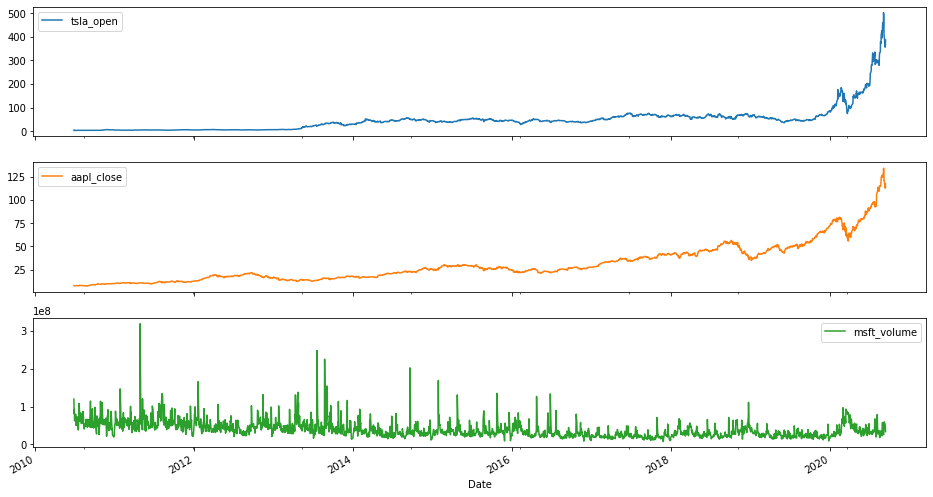

In [145]:
final_flattened_df[['tsla_open', 'aapl_close', 'msft_volume']].plot(subplots=True)

In [146]:
df = final_flattened_df.copy()

### Feature Engineering

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [147]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds

array([1.2777840e+09, 1.2778704e+09, 1.2779568e+09, ..., 1.5995376e+09,
       1.5996240e+09, 1.5997104e+09])

In [148]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

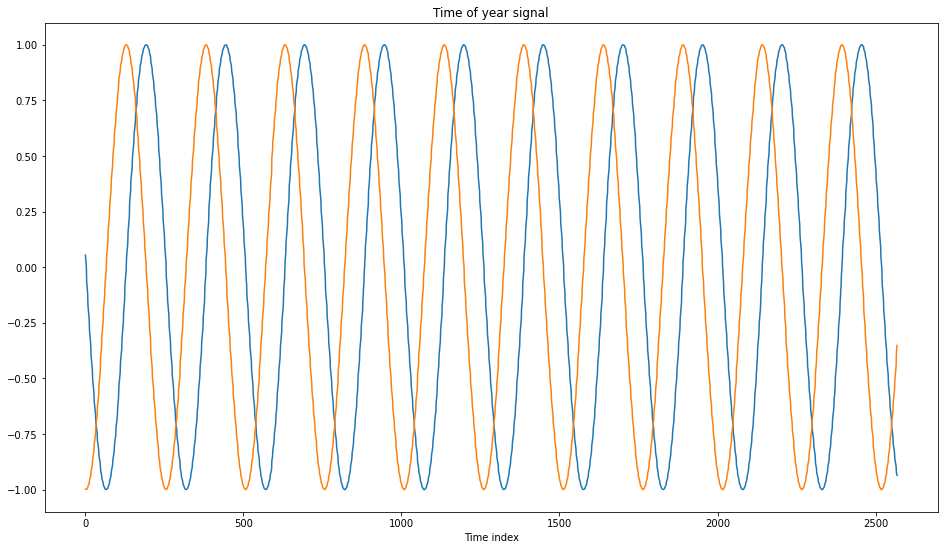

In [149]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15b3b5f70>,
      dtype=object)

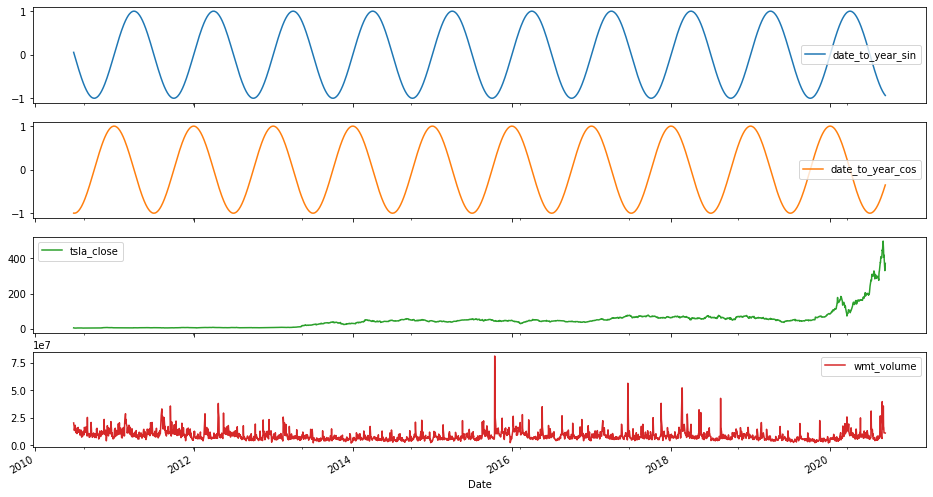

In [150]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'tsla_close', 'wmt_volume']].plot(subplots=True)

### Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [151]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [152]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the probability density of the data at different values. Using a [seaborn violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

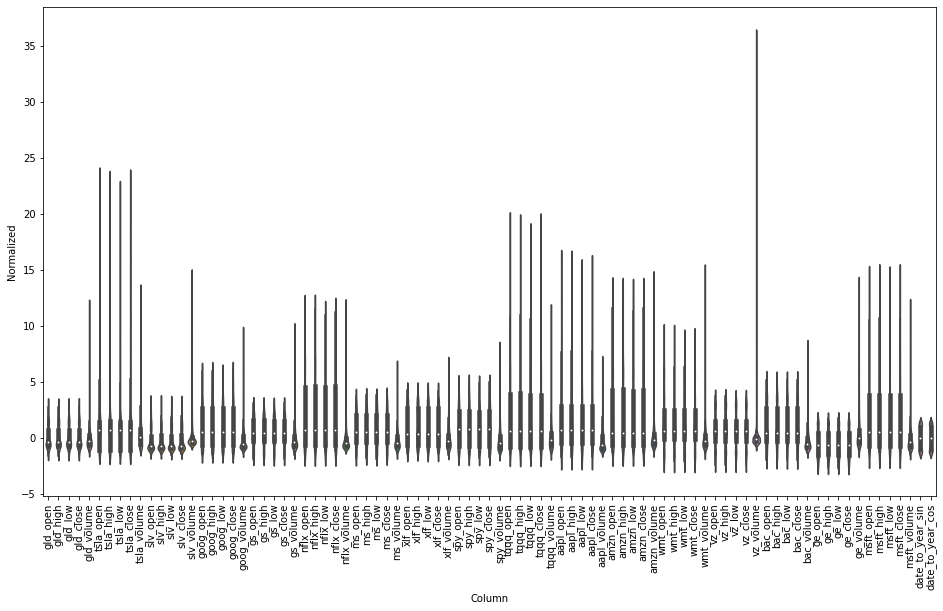

In [153]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

In [154]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='tsla_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure()
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [date]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### Single step models



In [155]:
label_columns = ['tsla_close']

In [156]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['tsla_close']

In [157]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 87)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [158]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [159]:
baseline = Baseline(label_index=column_indices[label_columns[0]])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

17/17 [==============================] - 0s 943us/step - loss: 0.0088 - mean_absolute_error: 0.0660


In [160]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['tsla_close']

In [161]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 87)
Output shape: (32, 1, 1)


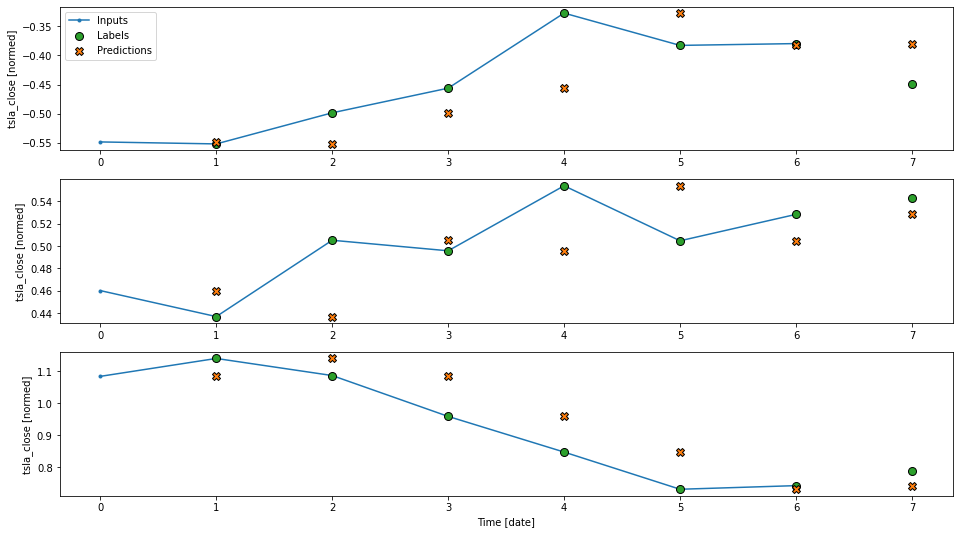

In [162]:
wide_window.plot(baseline)

In [163]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [164]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 87)
Output shape: (32, 1, 1)


In [165]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [166]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
57/57 [==============================] - 0s 3ms/step - loss: 0.7830 - mean_absolute_error: 0.7148 - val_loss: 4.5158 - val_mean_absolute_error: 1.9777
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.4209 - mean_absolute_error: 0.5192 - val_loss: 2.0670 - val_mean_absolute_error: 1.2954
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.2539 - mean_absolute_error: 0.3951 - val_loss: 0.8154 - val_mean_absolute_error: 0.7674
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.1640 - mean_absolute_error: 0.3122 - val_loss: 0.3516 - val_mean_absolute_error: 0.4784
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.1135 - mean_absolute_error: 0.2567 - val_loss: 0.2337 - val_mean_absolute_error: 0.3825
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0838 - mean_absolute_error: 0.2195 - val_loss: 0.1605 - val_mean_absolute_error: 0.3141
Epoch 7/50
57/57 [==========

In [167]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 7, 87)
Output shape: (32, 7, 1)


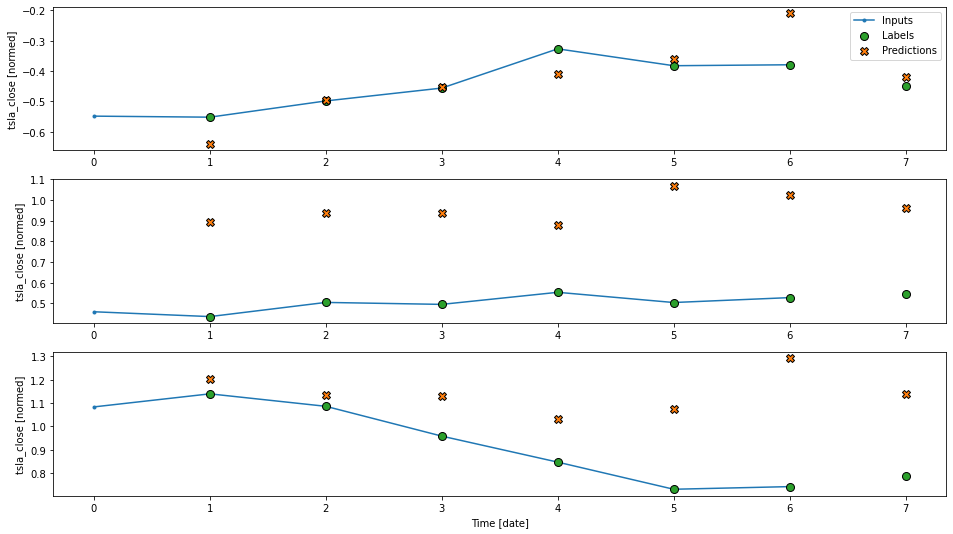

In [168]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

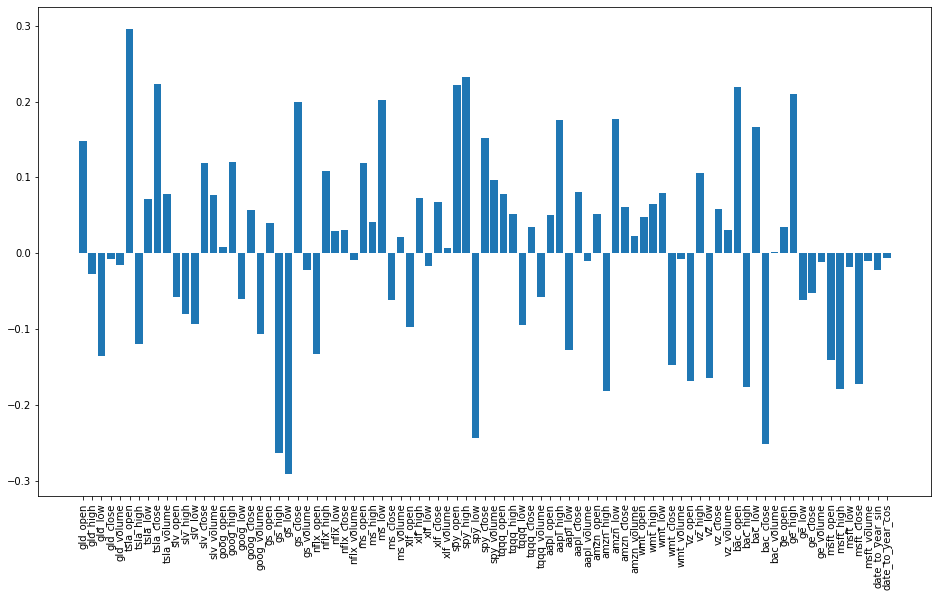

In [169]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `tsla_close`. This is one of the risks of random initialization.

### Dense

In [170]:
%%time
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1681 - mean_absolute_error: 0.2647 - val_loss: 1.2417 - val_mean_absolute_error: 0.9056
Epoch 2/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0212 - mean_absolute_error: 0.1116 - val_loss: 0.7139 - val_mean_absolute_error: 0.6580
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0908 - val_loss: 0.5058 - val_mean_absolute_error: 0.5521
Epoch 4/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0815 - val_loss: 0.7248 - val_mean_absolute_error: 0.6746
Epoch 5/50
8/8 [==============================] - 0s 530us/step - loss: 12.8582 - mean_absolute_error: 2.4531
CPU times: user 2.61 s, sys: 689 ms, total: 3.3 s
Wall time: 1.48 s


#### Multi-step dense

In [171]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['tsla_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

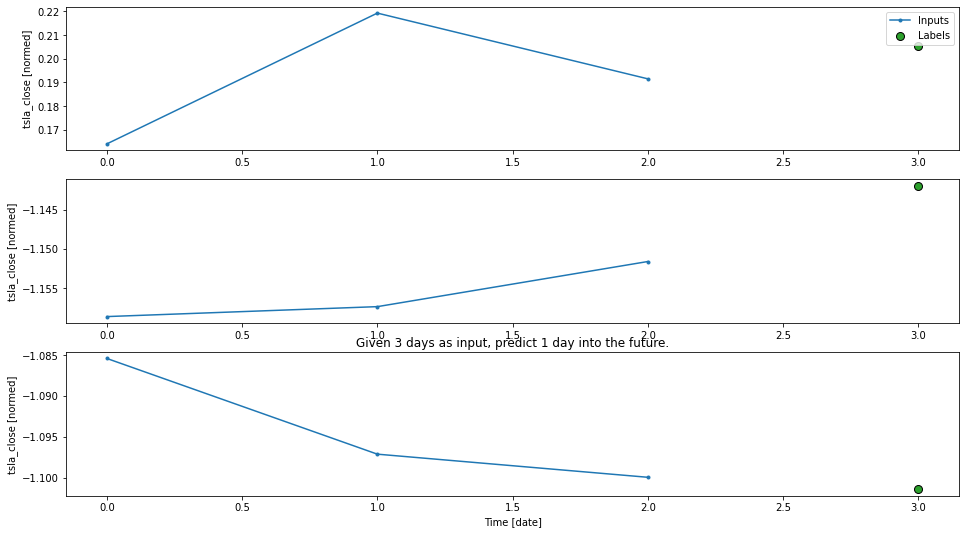

In [172]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [173]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [174]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 87)
Output shape: (32, 1, 1)


In [175]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

8/8 [==============================] - 0s 625us/step - loss: 9.5889 - mean_absolute_error: 2.5669
CPU times: user 1.77 s, sys: 503 ms, total: 2.27 s
Wall time: 987 ms


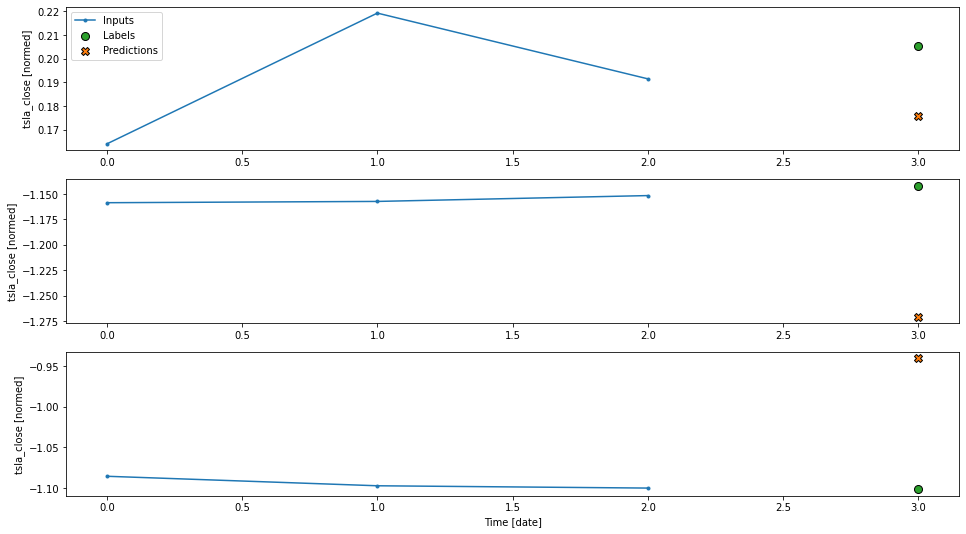

In [176]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [177]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 87)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,609], In[1]: [261,32] [Op:MatMul]


### Convolution neural network

In [178]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [179]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 87)
Output shape: (32, 1, 1)


In [180]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 880us/step - loss: 0.4820 - mean_absolute_error: 0.6000
CPU times: user 4.15 s, sys: 1.27 s, total: 5.42 s
Wall time: 2.07 s


In [181]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 87)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [182]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['tsla_close']

In [183]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 9, 87)
Labels shape: (32, 7, 1)
Output shape: (32, 7, 1)


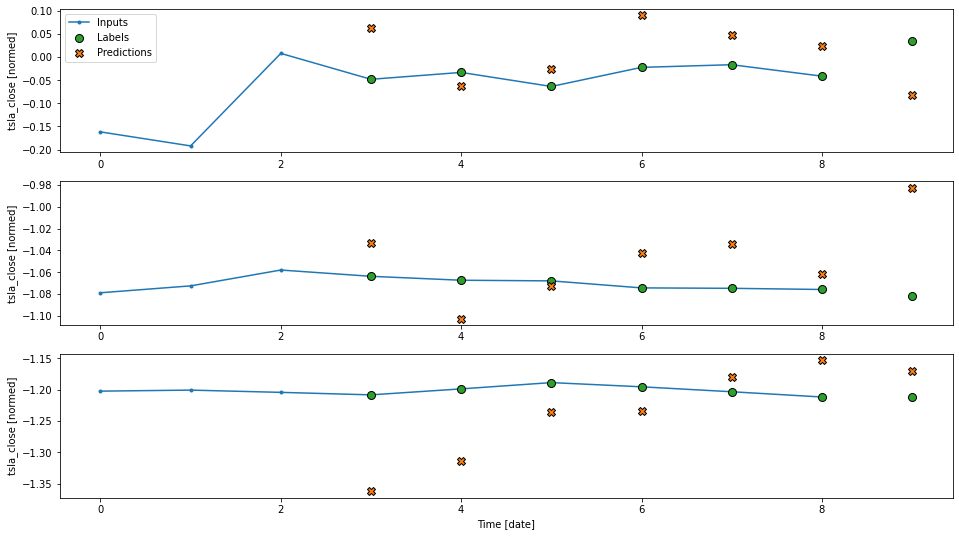

In [184]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [185]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [186]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 7, 87)
Output shape: (32, 7, 1)


In [187]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

8/8 [==============================] - 0s 841us/step - loss: 36.9822 - mean_absolute_error: 4.1288
CPU times: user 3.8 s, sys: 762 ms, total: 4.56 s
Wall time: 2.64 s


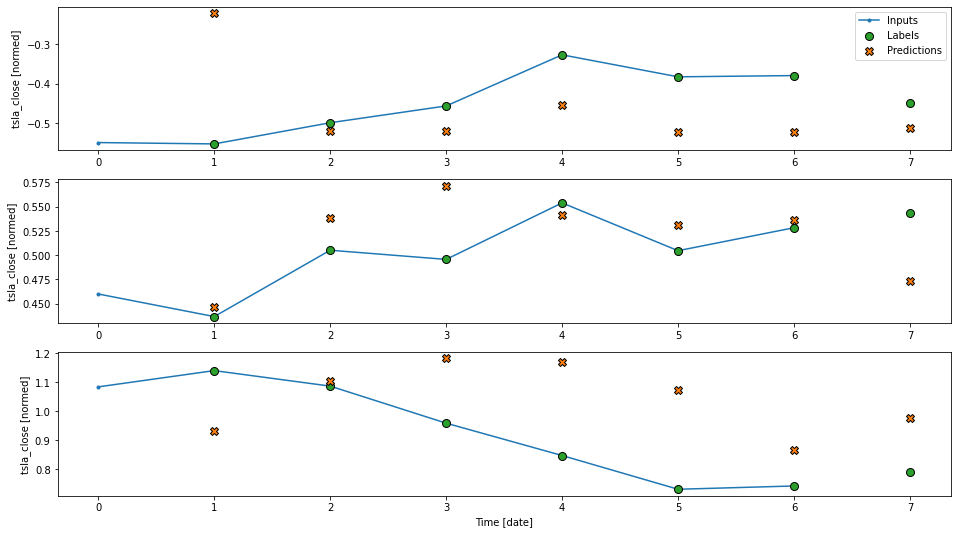

In [188]:
wide_window.plot(lstm_model)

### Performance

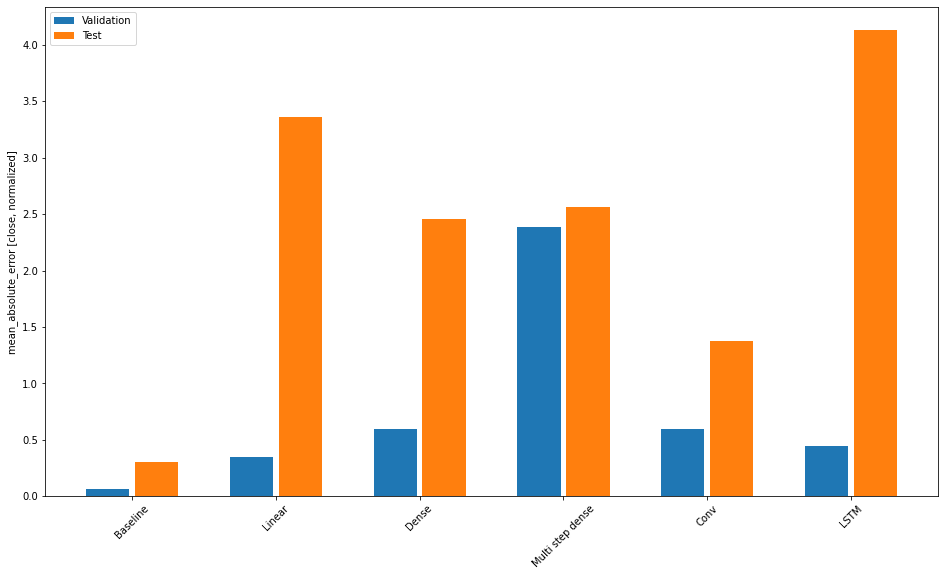

In [189]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [190]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.3083
Linear      : 3.3649
Dense       : 2.4531
Multi step dense: 2.5669
Conv        : 1.3720
LSTM        : 4.1288


### Multi Output Models

In [191]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 87)
Labels shape (batch, time, features): (32, 7, 87)


In [192]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [193]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

16/16 [==============================] - 0s 780us/step - loss: 0.0918 - mean_absolute_error: 0.1213


In [194]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [195]:
%%time
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

8/8 [==============================] - 0s 575us/step - loss: 4.3556 - mean_absolute_error: 1.5370
CPU times: user 6.29 s, sys: 2.07 s, total: 8.36 s
Wall time: 2.95 s


In [196]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [197]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [198]:
%%time
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


16/16 [==============================] - 0s 1ms/step - loss: 2.0653 - mean_absolute_error: 0.9894
CPU times: user 22.7 s, sys: 7.33 s, total: 30 s
Wall time: 10.8 s


In [199]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [200]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

16/16 [==============================] - 0s 2ms/step - loss: 0.0898 - mean_absolute_error: 0.1232

CPU times: user 4.94 s, sys: 1.18 s, total: 6.12 s
Wall time: 3.11 s


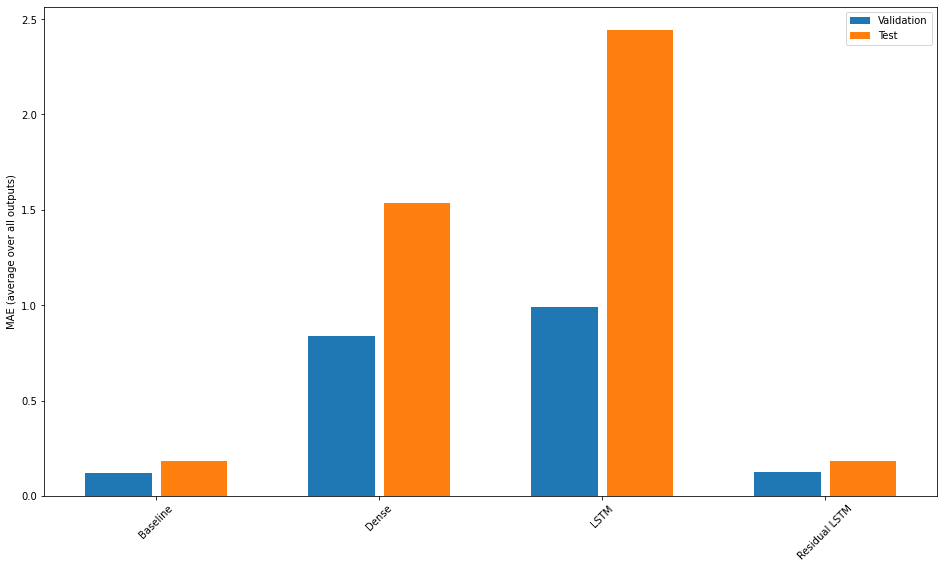

In [201]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

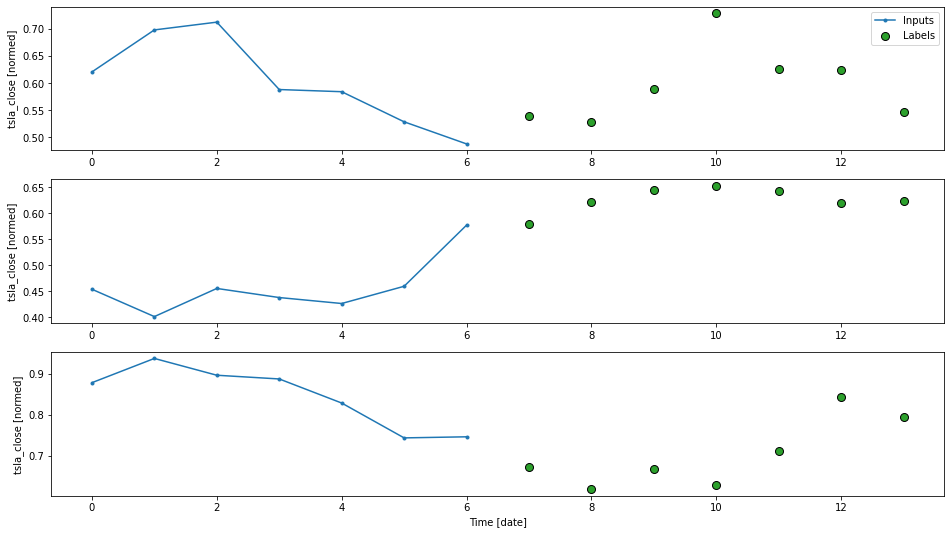

In [202]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

16/16 [==============================] - 0s 912us/step - loss: 0.1734 - mean_absolute_error: 0.1985


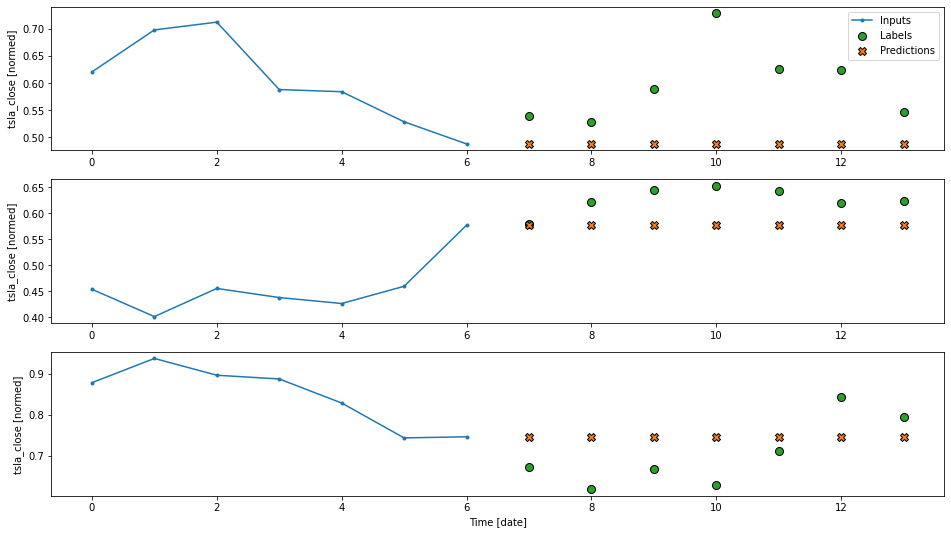

In [203]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

16/16 [==============================] - 0s 1ms/step - loss: 0.2219 - mean_absolute_error: 0.2513


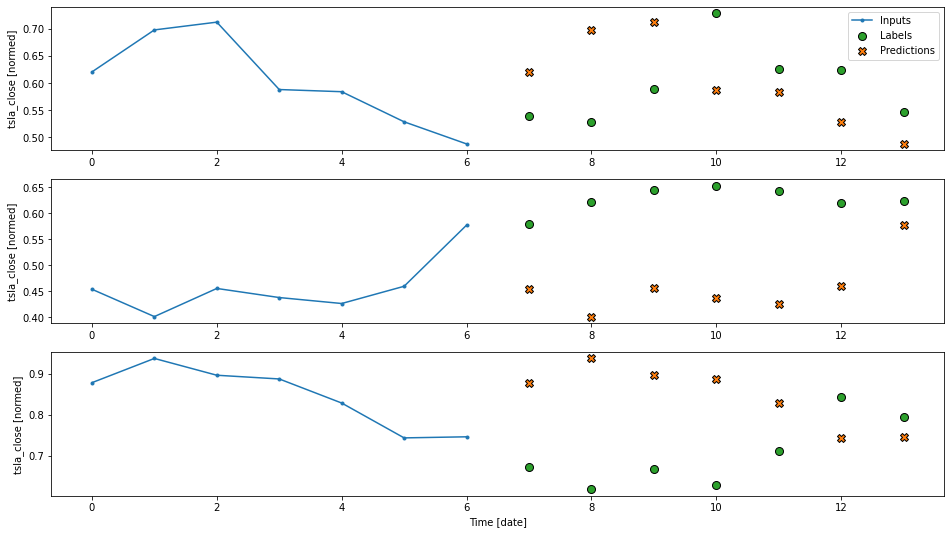

In [204]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

16/16 [==============================] - 0s 1ms/step - loss: 0.6747 - mean_absolute_error: 0.5758
CPU times: user 12.4 s, sys: 4.35 s, total: 16.8 s
Wall time: 5.32 s


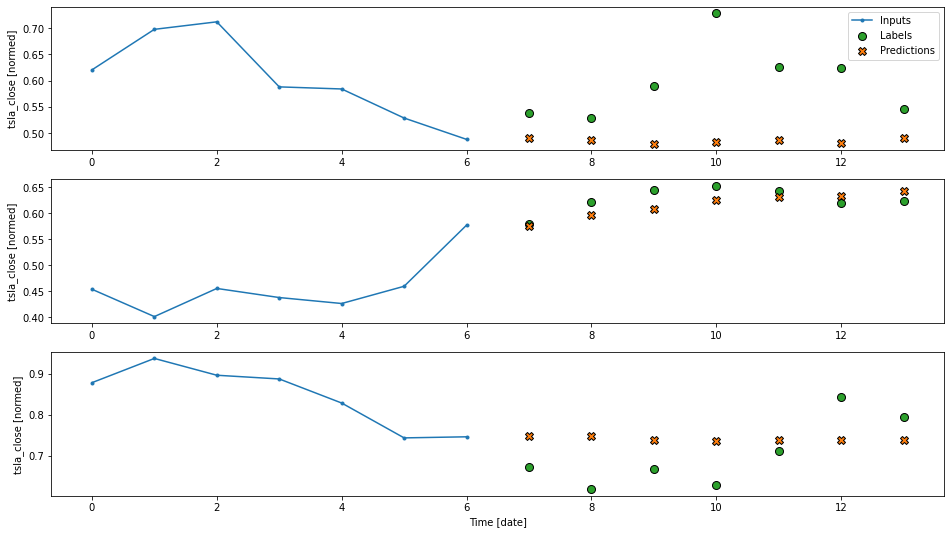

In [205]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15fb7d790>,
      dtype=object)

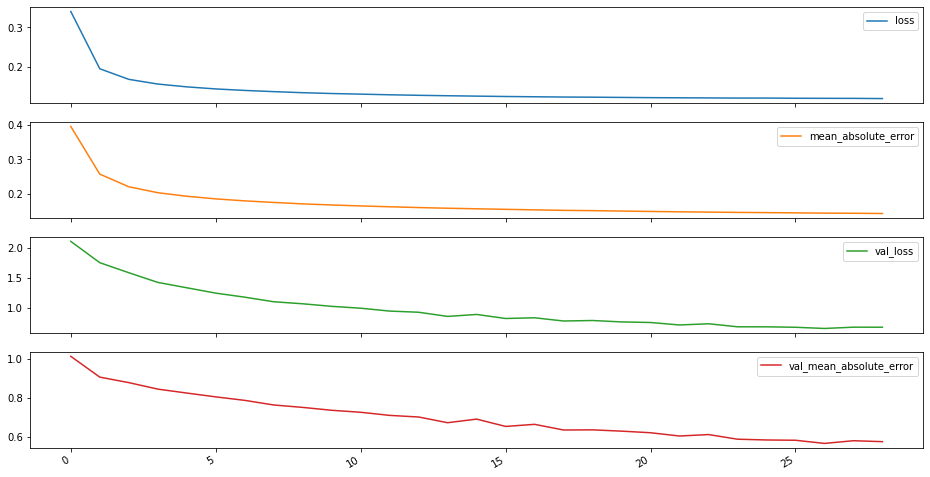

In [206]:
pd.DataFrame(history.history).plot(subplots=True)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

16/16 [==============================] - 0s 1ms/step - loss: 0.8876 - mean_absolute_error: 0.6873
CPU times: user 5.96 s, sys: 1.32 s, total: 7.28 s
Wall time: 2.52 s


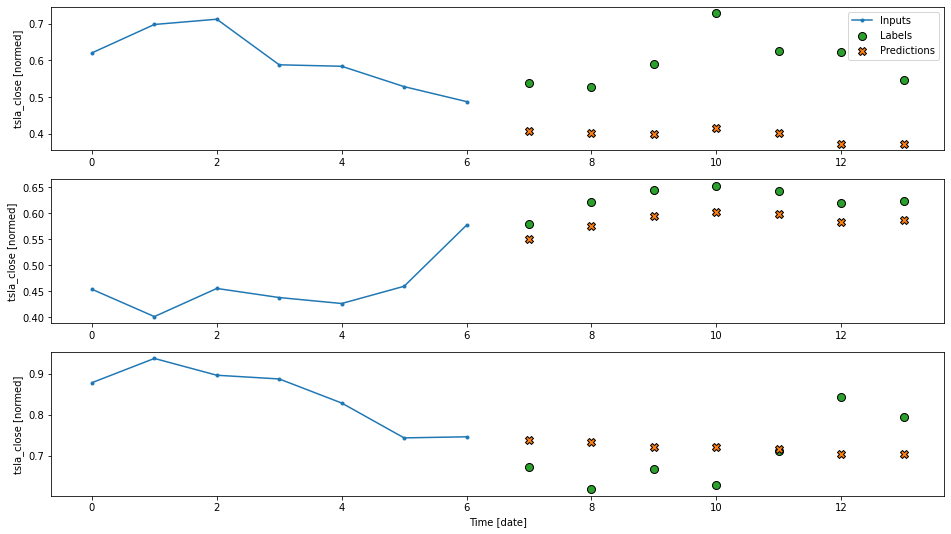

In [207]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15fedd910>,
      dtype=object)

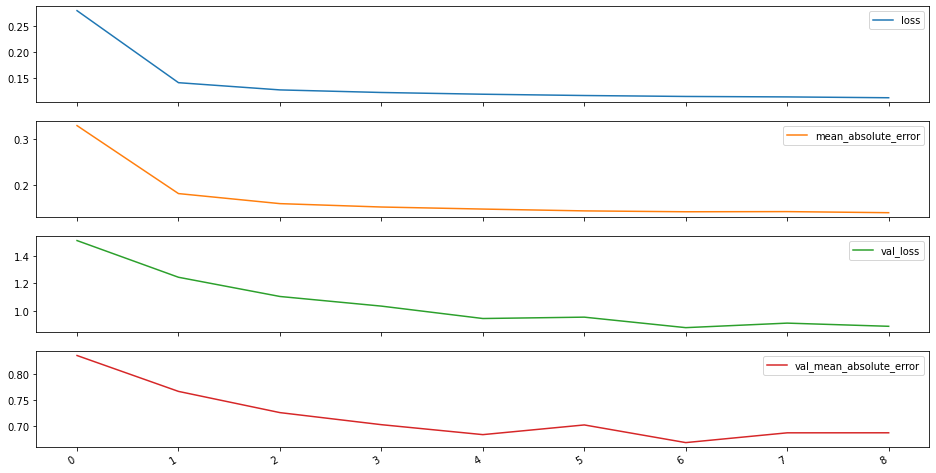

In [208]:
pd.DataFrame(history.history).plot(subplots=True)

### CNN

16/16 [==============================] - 0s 1ms/step - loss: 0.9769 - mean_absolute_error: 0.7113
CPU times: user 7.31 s, sys: 2.01 s, total: 9.32 s
Wall time: 3.04 s


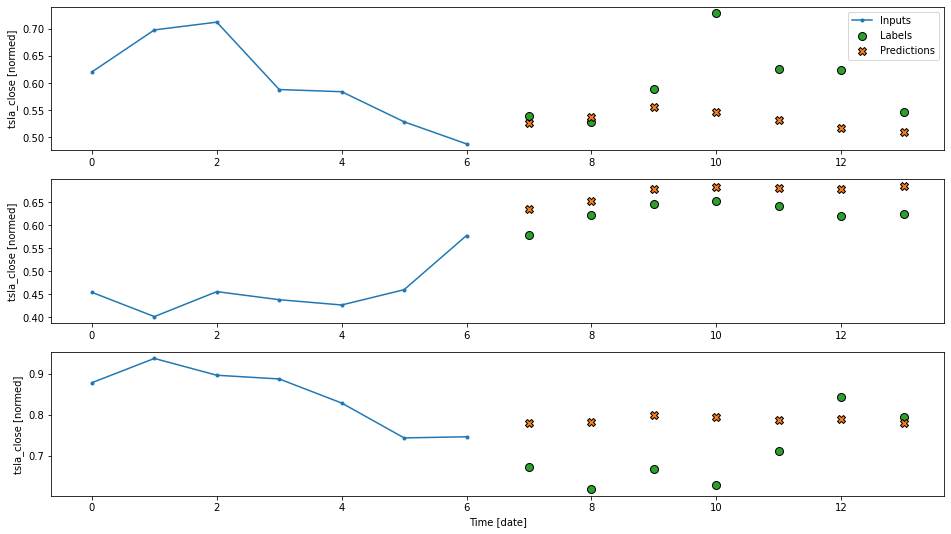

In [209]:
%%time
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x153a44d90>,
      dtype=object)

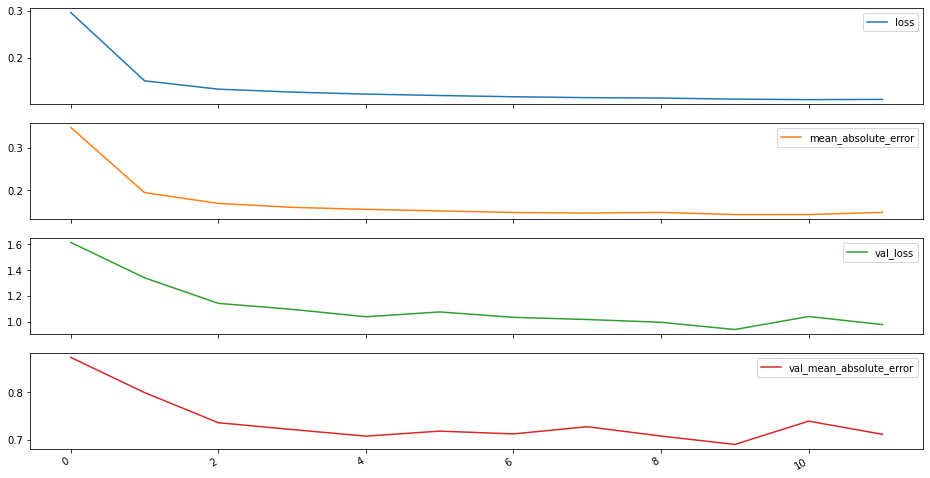

In [210]:
pd.DataFrame(history.history).plot(subplots=True)

### RNN

16/16 [==============================] - 0s 2ms/step - loss: 3.2049 - mean_absolute_error: 1.2787
CPU times: user 9.38 s, sys: 2.57 s, total: 12 s
Wall time: 5.18 s


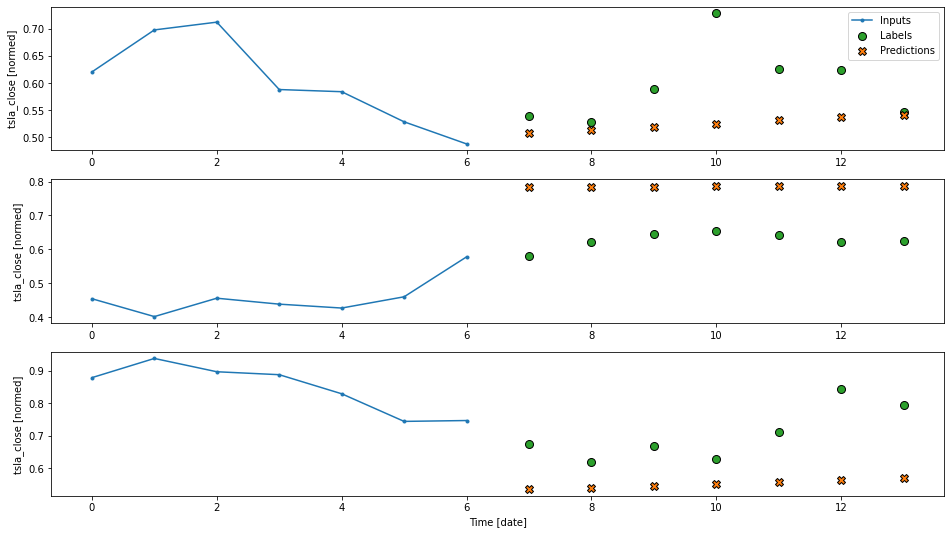

In [211]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1542f12b0>,
      dtype=object)

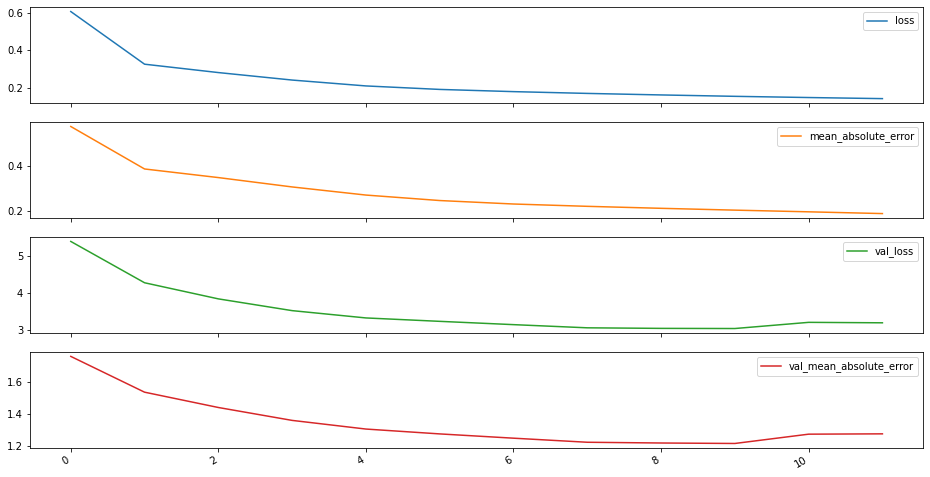

In [212]:
pd.DataFrame(history.history).plot(subplots=True)

### Advanced: Autoregressive model

#### RNN

In [213]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [214]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [215]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 87])

In [216]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 87)


16/16 [==============================] - 0s 1ms/step - loss: 3.1830 - mean_absolute_error: 1.2777
CPU times: user 8.06 s, sys: 2.12 s, total: 10.2 s
Wall time: 4.37 s


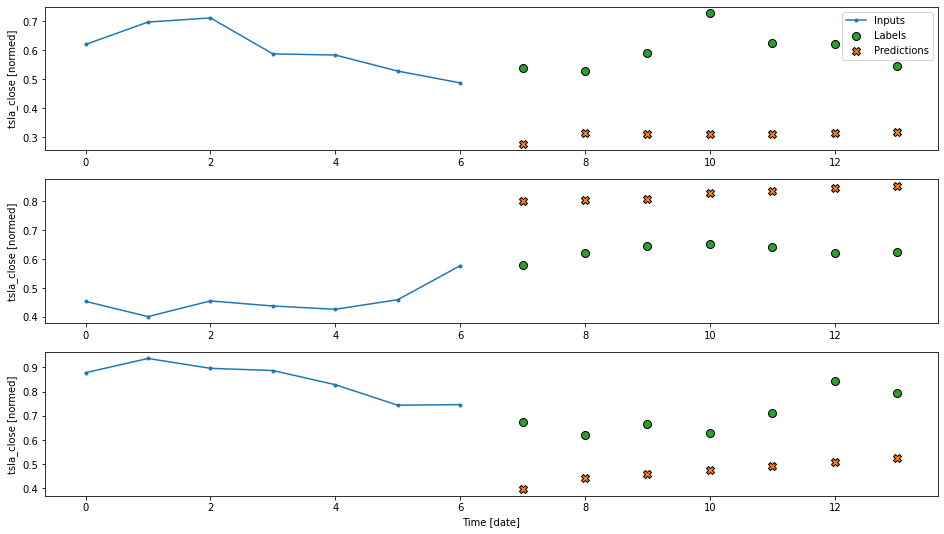

In [217]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x158c6ff40>,
      dtype=object)

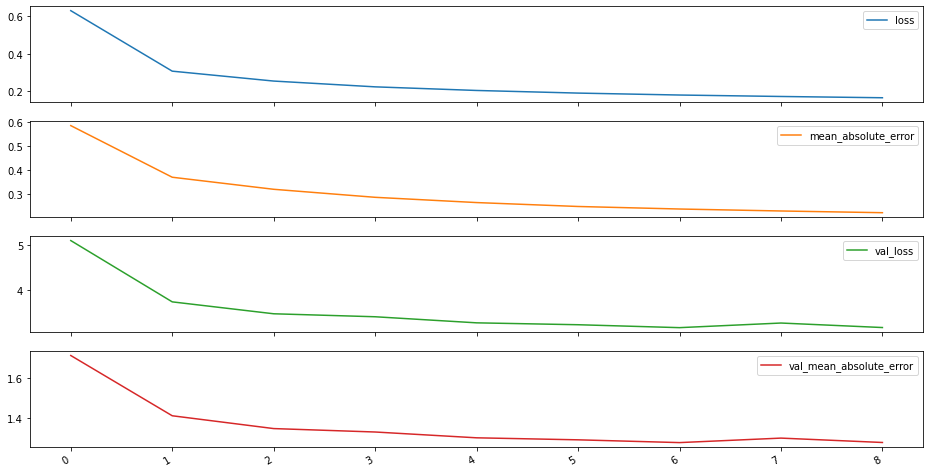

In [218]:
pd.DataFrame(history.history).plot(subplots=True)

### Reference Multi Step LSTM Models

[stacked-lstms-with-dropout](https://www.sciencedirect.com/science/article/pii/S1877050920304865)

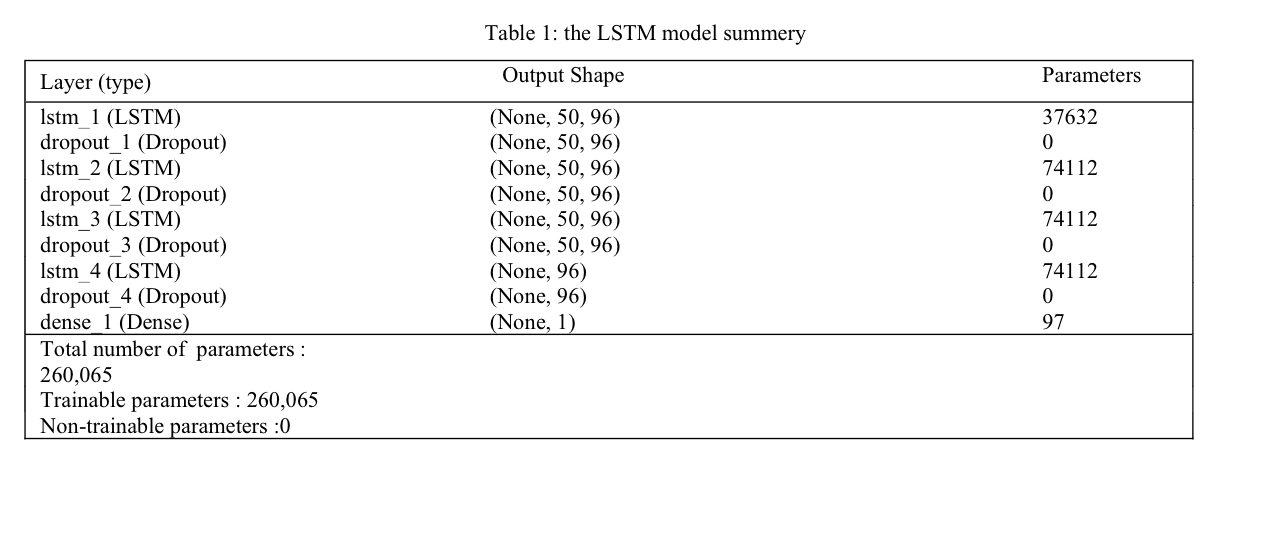

16/16 [==============================] - 0s 3ms/step - loss: 2.7661 - mean_absolute_error: 1.1778
CPU times: user 36.4 s, sys: 9.03 s, total: 45.4 s
Wall time: 17.1 s


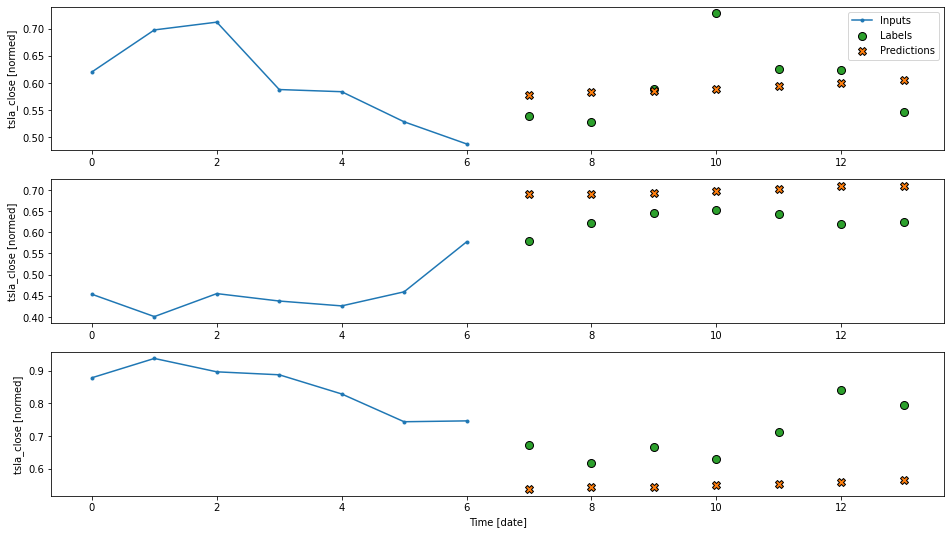

In [219]:
%%time
stacked_lstm_dropout_reference_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(stacked_lstm_dropout_reference_model, multi_window)

IPython.display.clear_output()
multi_val_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.val)
multi_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(stacked_lstm_dropout_reference_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15c3a2460>,
      dtype=object)

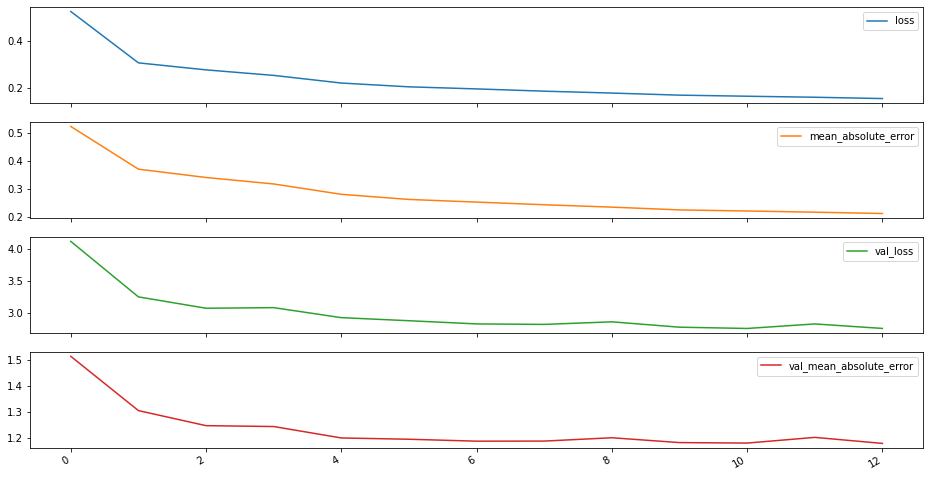

In [220]:
pd.DataFrame(history.history).plot(subplots=True)

### Custom Multi Step Models

Using a CNN with average pooling and dropout layer in front of stacked Bidirectional LSTM layers.

16/16 [==============================] - 0s 1ms/step - loss: 2.9379 - mean_absolute_error: 1.2257
CPU times: user 20 s, sys: 4.94 s, total: 25 s
Wall time: 10.6 s


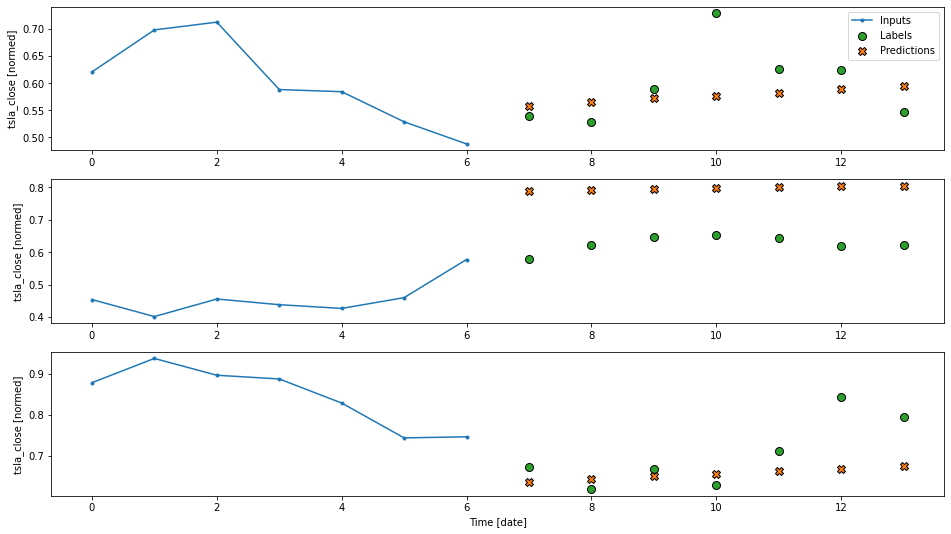

In [221]:
%%time
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()
multi_val_performance['custom_model'] = custom_model.evaluate(multi_window.val)
multi_performance['custom_model'] = custom_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(custom_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15a865f10>,
      dtype=object)

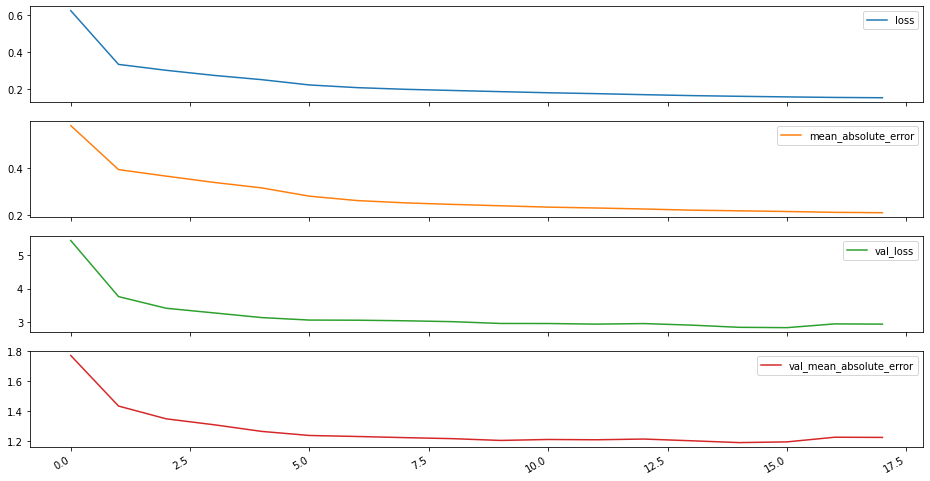

In [222]:
pd.DataFrame(history.history).plot(subplots=True)

### Performance

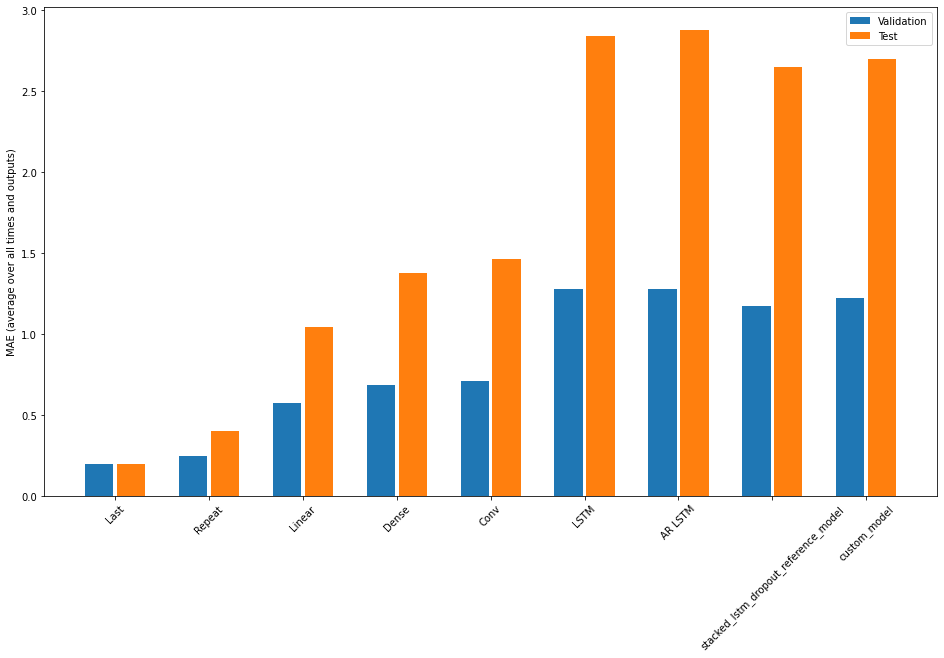

In [223]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [224]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.1985
Repeat  : 0.4034
Linear  : 1.0480
Dense   : 1.3762
Conv    : 1.4625
LSTM    : 2.8434
AR LSTM : 2.8770
stacked_lstm_dropout_reference_model: 2.6511
custom_model: 2.6972


Peeking at some other predictions made by the custom model... it predicts all features!

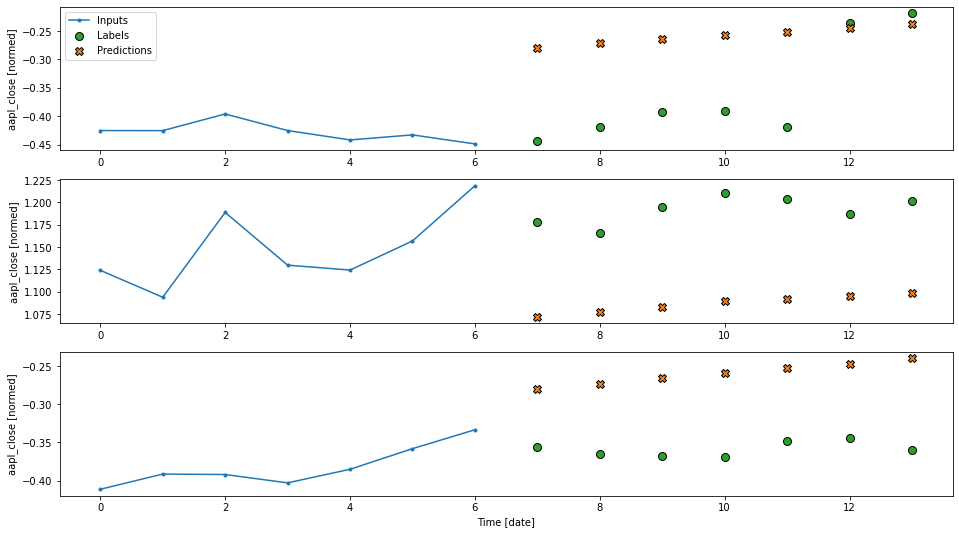

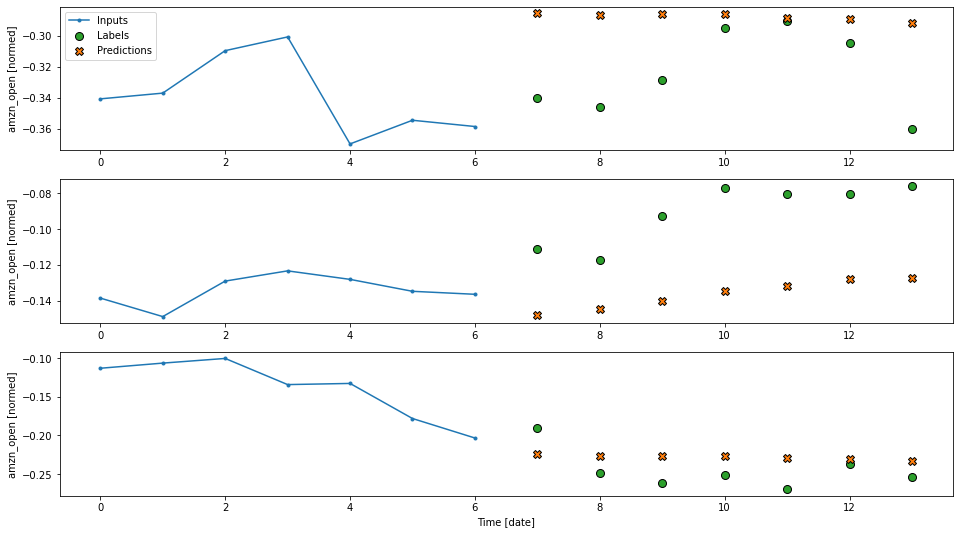

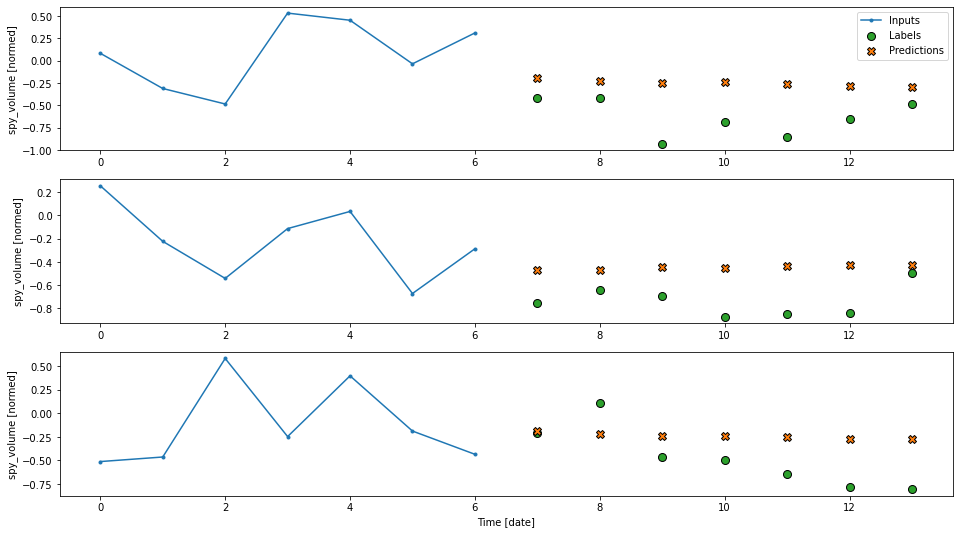

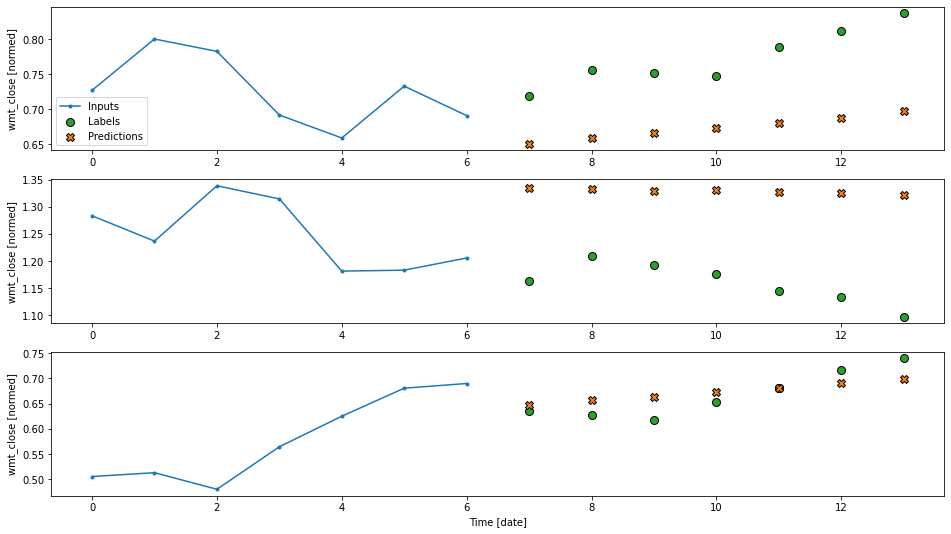

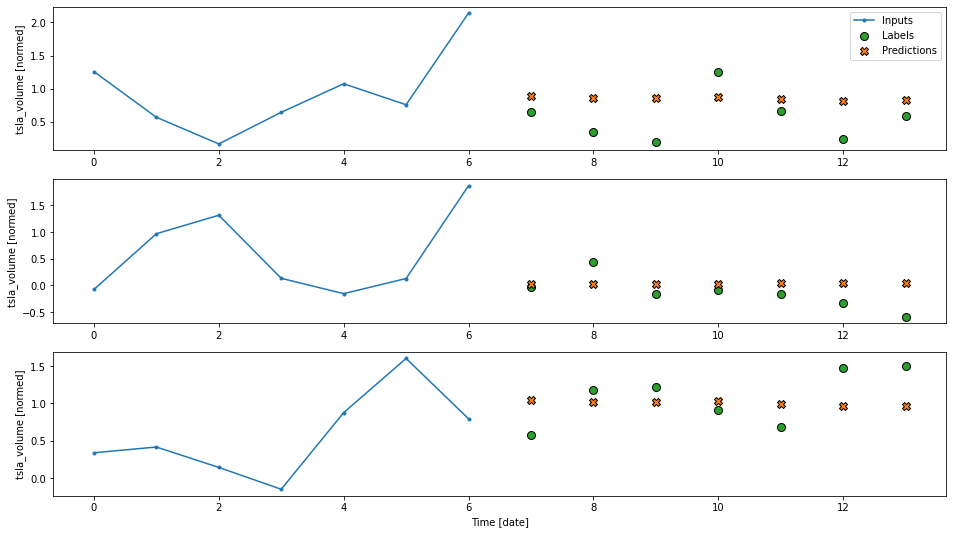

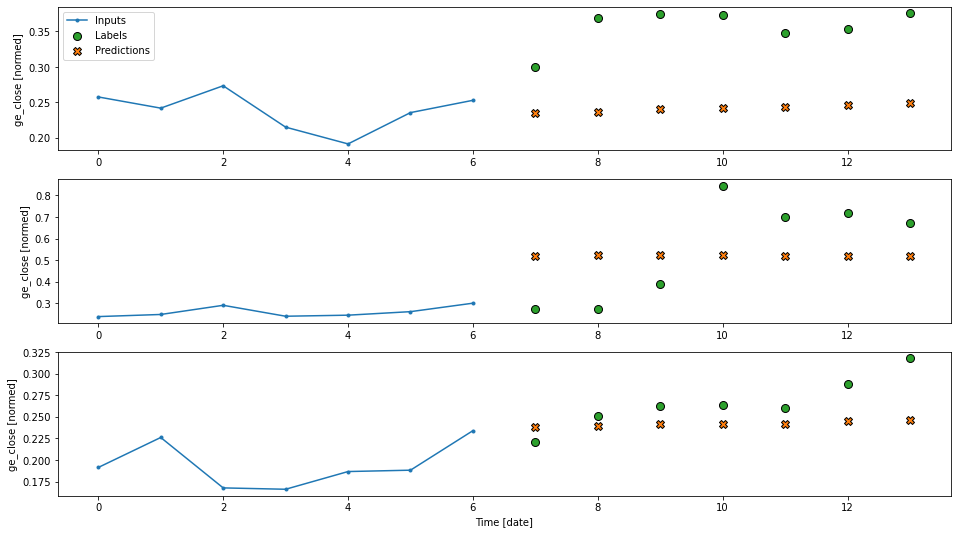

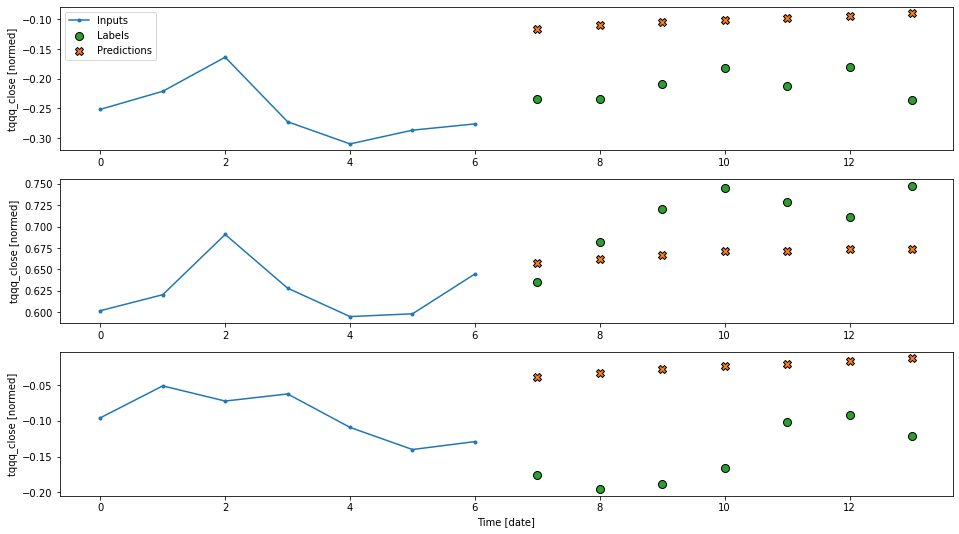

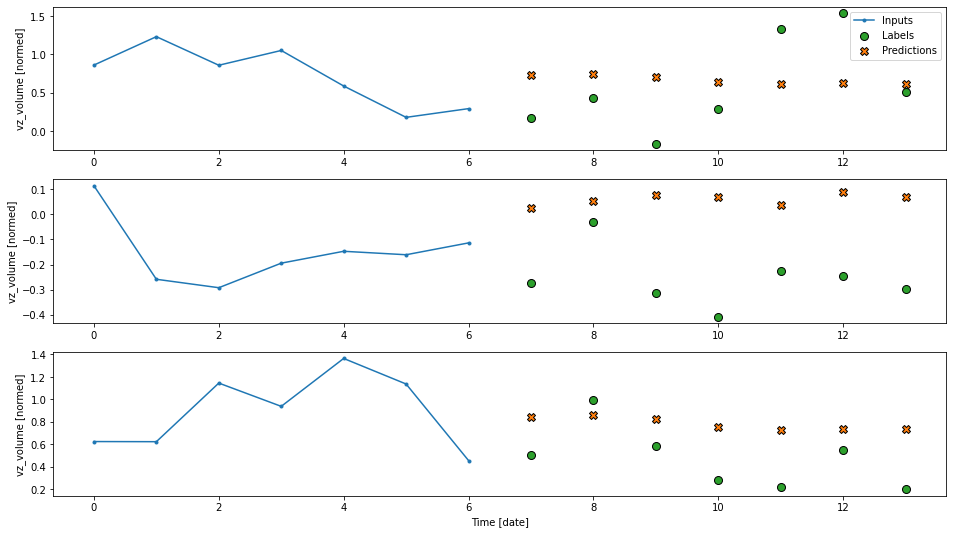

In [225]:
for plot_col in ['aapl_close', 'amzn_open', 'spy_volume', 'wmt_close', 'tsla_volume', 'ge_close', 'tqqq_close', 'vz_volume']:
    multi_window.plot(custom_model, plot_col)

Store the trained model weights

In [226]:
custom_model.save_weights('./checkpoints/custom-model')

### Making predictions with the saved model